In [14]:
import os
import torch
import torch.nn as nn
import torch.distributions as td
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import trange

from flow.nvp import RealNVP

In [15]:
# Data
data_dim = 2
noise = 0.05
# Model
H = 256 # Hidden size
L = 3 # Layers
# Optimisation
lr = 3e-4
n_steps = 10_000
batch_size = 400

In [16]:
# These functions return their modules inside the flow module
net_s = lambda: nn.Sequential(
    nn.Linear(data_dim, H), 
    nn.Tanh(),
    nn.Linear(H, H), 
    nn.Tanh(),
    nn.Linear(H, data_dim), 
    nn.Tanh()
)
net_t = lambda: nn.Sequential(
    nn.Linear(data_dim, H), 
    nn.Tanh(), 
    nn.Linear(H, H), 
    nn.Tanh(), 
    nn.Linear(H, data_dim)
)

masks = torch.from_numpy(np.array([[0., 1.], [1., 0.]] * 3)).float()

prior = td.MultivariateNormal(torch.zeros(data_dim), torch.eye(data_dim))

flow = RealNVP(net_s, net_t, masks, prior)

In [17]:
field_type = "LN"
data_dir = "data/"
X = np.load(os.path.join(data_dir, field_type + "_nn_summaries.npy"))
Y = np.load(os.path.join(data_dir, "field_parameters.npy"))

print(X.shape, Y.shape)

(20000, 2) (20000, 2)


In [18]:
def get_data(n):
    ix = np.random.randint(len(X), size=(n,))
    return torch.as_tensor(X[ix]).float(), torch.as_tensor(Y[ix]).float()

optimizer = torch.optim.Adam(
    [p for p in flow.parameters() if p.requires_grad], lr=lr
)
losses = []
with trange(n_steps) as steps:
    for t in steps:    

        x, y = get_data(batch_size)

        loss = -flow.log_prob(x).mean()
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        losses.append(loss.item())
        steps.set_postfix(loss=f"{loss:.3E}")

t=00000 loss=2.147E+00
t=00500 loss=-1.062E+00
t=01000 loss=-1.103E+00
t=01500 loss=-1.147E+00
t=02000 loss=-1.125E+00
t=02500 loss=-1.152E+00
t=03000 loss=-1.175E+00
t=03500 loss=-1.173E+00
t=04000 loss=-1.211E+00
t=04500 loss=-1.170E+00
t=05000 loss=-1.174E+00
t=05500 loss=-1.181E+00
t=06000 loss=-1.141E+00
t=06500 loss=-1.167E+00
t=07000 loss=-1.174E+00
t=07500 loss=-1.197E+00
t=08000 loss=-1.200E+00
t=08500 loss=-1.152E+00
t=09000 loss=-1.162E+00
t=09500 loss=-1.149E+00


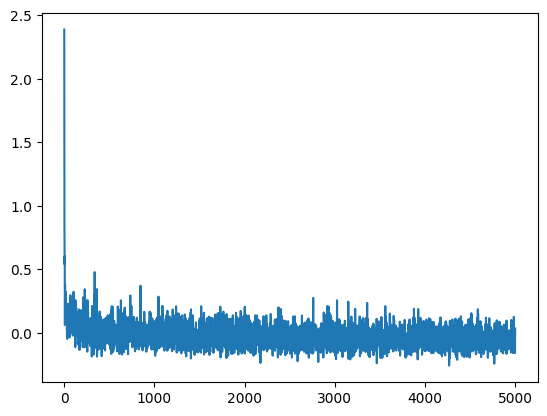

In [6]:
plt.figure()
plt.plot(losses)
plt.show()

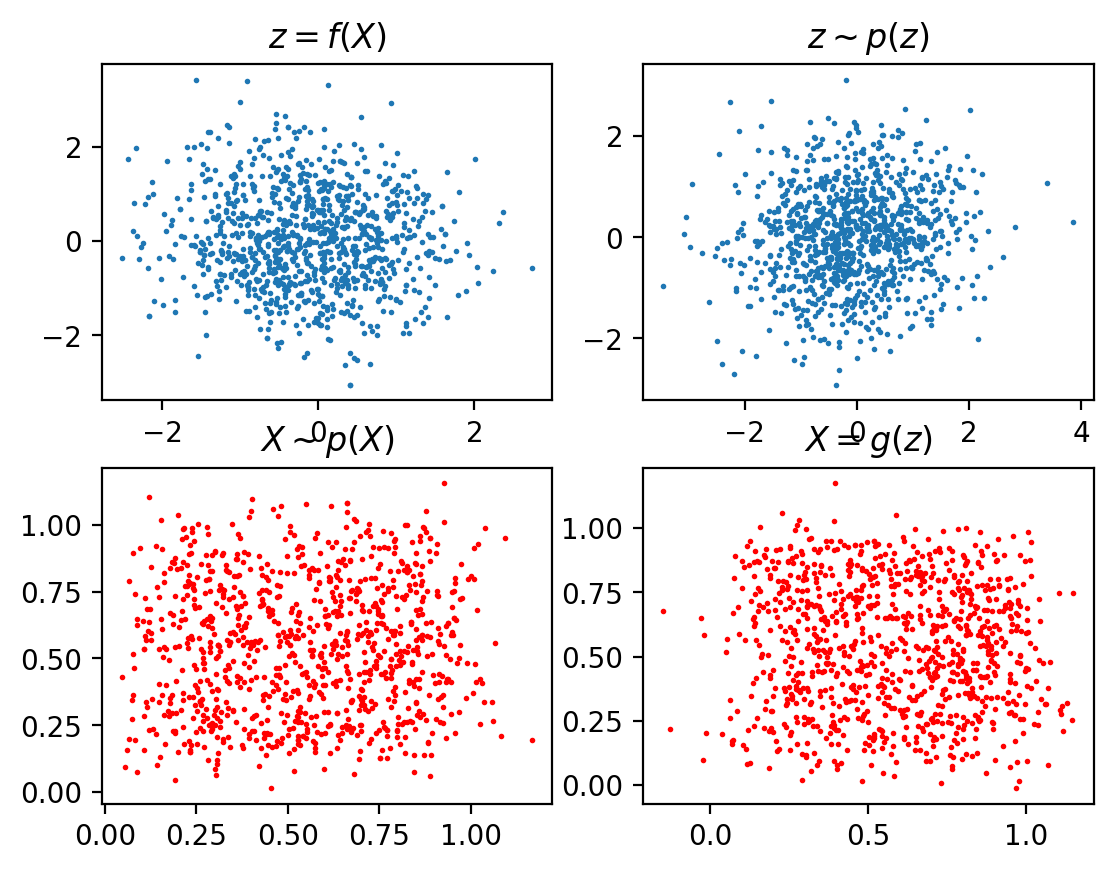

In [7]:
plt.figure(dpi=200)

x, y = get_data(n=1000)
z = flow.forward(x)[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1], s=1.)
plt.title(r'$z = f(X)$')

z = prior.sample((1000,))
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1], s=1.)
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x, y = get_data(n=1000)
plt.scatter(x[:, 0], x[:, 1], c='r', s=1.)
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r', s=1.)
plt.title(r'$X = g(z)$')

plt.show()

In [13]:
def sample(log_prob, n_params, n_walkers, n_steps, walkers1, walkers2):

    # Progress-bar
    pbar = tqdm(total=n_steps, desc="Sampling")  # Jupyter notebook or qtconsole

    # Initialize current state
    current_state1 = torch.as_tensor(walkers1)
    current_state2 = torch.as_tensor(walkers2)

    # Initial target log prob for the walkers (and set any nans to -inf)...
    logp_current1 = log_prob(current_state1)
    logp_current2 = log_prob(current_state2)

    logp_current1 = torch.as_tensor(logp_current1)
    logp_current2 = torch.as_tensor(logp_current2)

    logp_current1 = torch.where(
        torch.isnan(logp_current1),
        torch.ones_like(logp_current1).fill_(float("inf")),
        logp_current1)
    logp_current2 = torch.where(
        torch.isnan(logp_current2),
        torch.ones_like(logp_current2).fill_(float("inf")),
        logp_current2)

    # Holder for the whole chain
    chain = [torch.cat([current_state1, current_state2], axis=0)]


    # MCMC loop
    for epoch in range(1, n_steps):

        # FIRST SET OF WALKERS:
        # Proposals
        #idx1 = torch.as_tensor(np.random.randint(0, n_walkers, n_walkers))
        idx1 = torch.randint(low=0, high=n_walkers, size=(n_walkers,))
        partners1 = current_state2[idx1]
        z1 = 0.5 * (torch.rand((n_walkers,)) + 1) ** 2
        proposed_state1 = partners1 + (z1 * (current_state1 - partners1).T).T

        # Target log prob at proposed points
        logp_proposed1 = log_prob(proposed_state1)
        logp_proposed1 = torch.as_tensor(logp_proposed1)
        logp_proposed1 = torch.where(
            torch.isnan(logp_proposed1),
            torch.ones_like(logp_proposed1).fill_(float("inf")),
            logp_proposed1)

        # Acceptance probability
        p_accept1 = torch.minimum(
            torch.ones(n_walkers),
            z1 ** (n_params - 1) * torch.exp(logp_proposed1 - logp_current1))

        # Accept or not
        accept1_ = torch.rand((n_walkers,)) <= p_accept1
        accept1 = accept1_.type(torch.float32)

        # Update the state
        current_state1 = (
            (current_state1).T * (1 - accept1) + (proposed_state1).T * accept1).T
        logp_current1 = torch.where(accept1_, logp_proposed1, logp_current1)

        # SECOND SET OF WALKERS:
        # Proposals
        #idx2 = torch.as_tensor(np.random.randint(0, n_walkers, n_walkers))
        idx2 = torch.randint(low=0, high=n_walkers, size=(n_walkers,))
        partners2 = current_state1[idx2]
        z2 = 0.5 * (torch.rand((n_walkers,)) + 1) ** 2
        proposed_state2 = partners2 + (z2 * (current_state2 - partners2).T).T

        # Target log prob at proposed points
        logp_proposed2 = log_prob(proposed_state2)
        logp_proposed2 = torch.as_tensor(logp_proposed2)
        logp_proposed2 = torch.where(
            torch.isnan(logp_proposed2),
            torch.ones_like(logp_proposed2).fill_(float("inf")),
            logp_proposed2)

        # Acceptance probability
        p_accept2 = torch.minimum(
            torch.ones(n_walkers),
            z2 ** (n_params - 1) * torch.exp(logp_proposed2 - logp_current2))

        # Accept or not
        accept2_ = torch.rand((n_walkers,)) <= p_accept2
        accept2 = accept2_.type(torch.float32)

        # Update the state
        current_state2 = (
            (current_state2).T * (1 - accept2) + (proposed_state2).T * accept2).T
        logp_current2 = torch.where(accept2_, logp_proposed2, logp_current2)

        # Append to chain
        chain.append(torch.cat([current_state1, current_state2], axis=0))

        # Update the progressbar
        pbar.update(1)

    # Stack up the chain
    chain = torch.stack(chain, axis=0)

    # Chain = np.unique(chain, axis=0) # this may need to be here,
    return chain[1:, :, :]

In [12]:
sample(partial(flow.log_prob(y=Y__)))

/Users/Jed.Homer/phd/teaching/sbi_ml_lab/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Warmup [1]:   0%|          | 0/2100 [00:00, ?it/s]

NameError: name 'data' is not defined